# Imports and configs

In [1]:
!pip install hill_climbing scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from hill_climbing import Climber, ClimberCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cupy as cp
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"

    target = "Calories"
    n_folds = 5
    seed = 42

# Loading OOF files

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
X, y = train.drop(CFG.target, axis=1), np.log1p(train[CFG.target])

def get_scores(oof_preds):    
    scores = []
    kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in kf.split(X, y):
        score = root_mean_squared_error(y[val_idx], oof_preds[val_idx])
        scores.append(score)
    return scores

In [5]:
scores = {}

oof_preds = joblib.load("/kaggle/input/s05e05-calorie-expenditure-prediction-ridge/oof_preds.pkl")
test_preds = joblib.load("/kaggle/input/s05e05-calorie-expenditure-prediction-ridge/test_preds.pkl")

for col in oof_preds.columns.tolist():
    scores[col] = get_scores(oof_preds[col])

# Hill climbing

In [6]:
def rmse(y_true, y_pred):
    return cp.sqrt(cp.mean((y_true - y_pred) ** 2))

In [7]:
climber = Climber(
    objective="minimize",
    eval_metric=rmse,
    allow_negative_weights=True,
    precision=0.001,
    score_decimal_places=6,
    n_jobs=1,
    use_gpu=True
).fit(oof_preds, y)

Configuration

   Metric:                       rmse
   Objective:                    minimize
   Precision:                    0.001
   Allow negative weights:       True
   Starting model:               best
   Number of parallel jobs:      1
   Number of models:             8
   Using GPU:                    True


Models

   AutoGluon         0.059001 █ (best)
   CatBoost          0.059239 ███
   LightGBM (goss)   0.059748 ███████████
   LightGBM (gbdt)   0.059787 ███████████
   HistGB            0.059828 ████████████
   XGBoost           0.060569 ███████████████████████
   Yggdrasil         0.060579 ███████████████████████
   KerasANN          0.061638 ████████████████████████████████████████


Running Hill Climbing

   Iter   Model               Weight        Score      Improvement         Time
   ────────────────────────────────────────────────────────────────────────────
      0   AutoGluon            1.000     0.059001                -            -
      1   CatBoost          

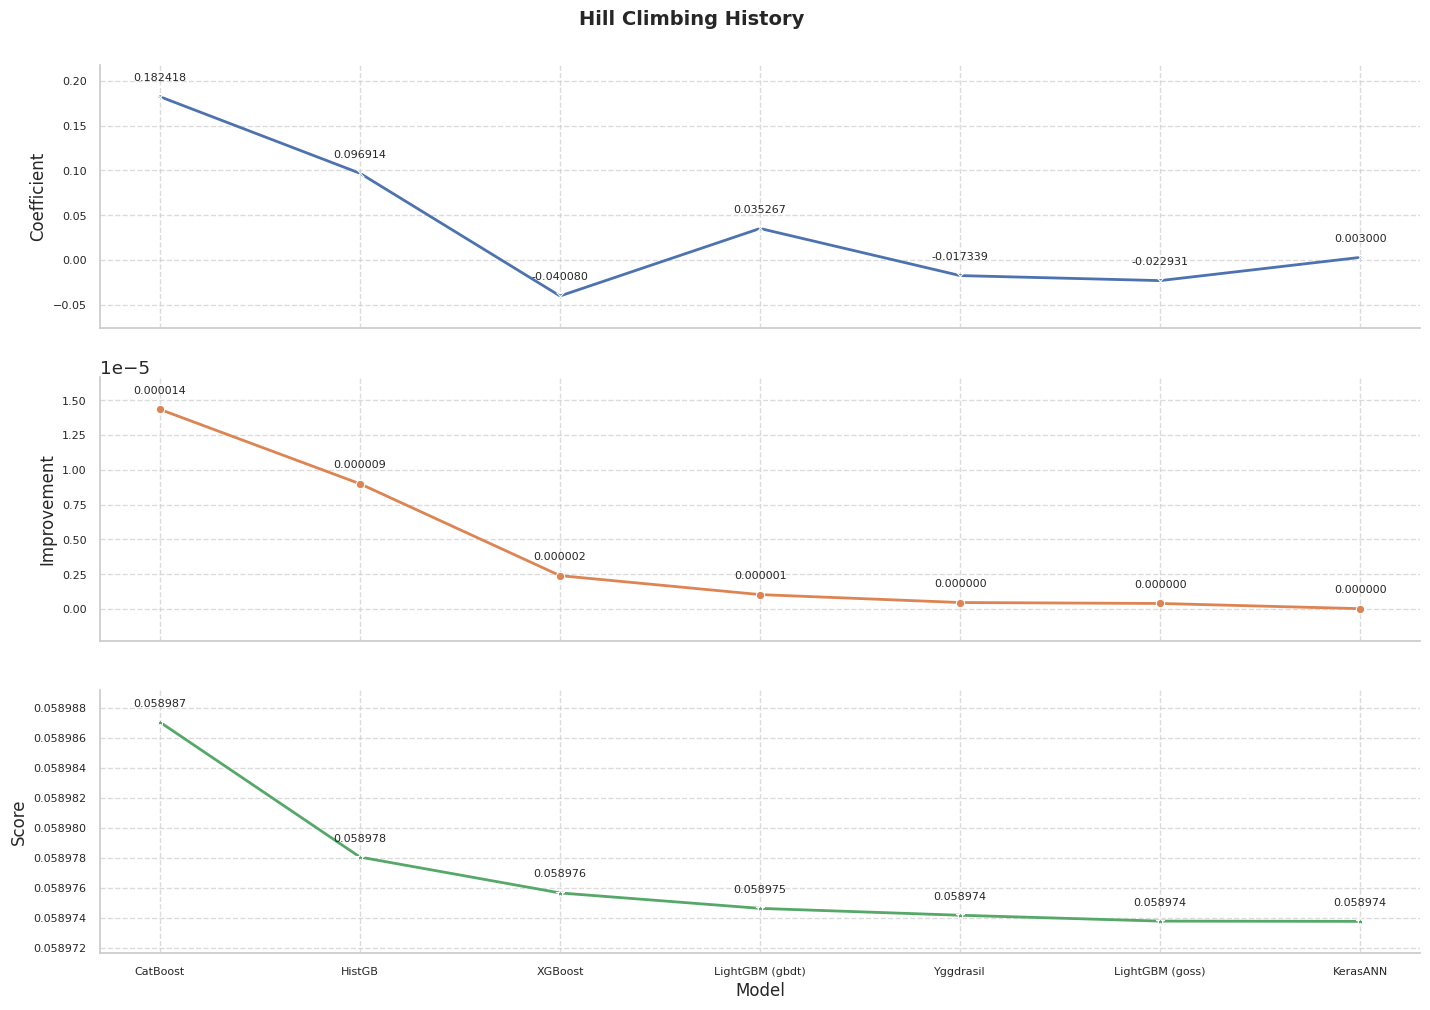

In [8]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context("notebook", font_scale=1.2)

def add_annotations(ax, x, y):
    for xi, yi in zip(x, y):
        ax.annotate(
            f'{yi:.6f}', (xi, yi),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            va='bottom',
            fontsize=8
        )

history = climber.history

palette = sns.color_palette("deep")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

sns.lineplot(x=history.model[1:], y=history.coef[1:], color=palette[0], marker='x', ax=ax1, linewidth=2)
add_annotations(ax1, history.model[1:], history.coef[1:])
ax1.set_ylabel('Coefficient', fontsize=12)
ax1.spines[['top', 'right']].set_visible(False)

sns.lineplot(x=history.model[1:], y=history.improvement[1:], color=palette[1], marker='o', ax=ax2, linewidth=2)
add_annotations(ax2, history.model[1:], history.improvement[1:])
ax2.set_ylabel('Improvement', fontsize=12)
ax2.spines[['top', 'right']].set_visible(False)

sns.lineplot(x=history.model[1:], y=history.score[1:], color=palette[2], marker='*', ax=ax3, linewidth=2)
add_annotations(ax3, history.model[1:], history.score[1:])
ax3.set_ylabel('Score', fontsize=12)
ax3.set_xlabel('Model', fontsize=12)
ax3.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
fig.suptitle('Hill Climbing History', y=1.02, fontsize=14, fontweight='bold')

for ax in [ax1, ax2, ax3]:
    ax.tick_params(labelsize=8)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - (ymax-ymin)*0.1, ymax + (ymax-ymin)*0.1)

plt.show()

In [9]:
scores["Hill Climbing"] = [climber.best_score] * CFG.n_folds

sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = np.expm1(climber.predict(test_preds))
sub.to_csv(f"sub_hill-climbing_{climber.best_score:.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.200802
1,750001,107.733299
2,750002,87.209545
3,750003,125.760903
4,750004,75.971745


# Hill climbing with cross-validation

In [10]:
climber_cv = ClimberCV(
    objective="minimize",
    eval_metric=rmse,
    allow_negative_weights=True,
    precision=0.001,
    score_decimal_places=6,
    n_jobs=1,
    use_gpu=True,
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
).fit(oof_preds, y)

Configuration

   Metric:                       rmse
   Objective:                    minimize
   Precision:                    0.001
   Allow negative weights:       True
   Starting model:               best
   Number of parallel jobs:      1
   Number of models:             8
   Number of folds:              5


Models

   AutoGluon         0.059001 █ (best)
   CatBoost          0.059239 ███
   LightGBM (goss)   0.059748 ███████████
   LightGBM (gbdt)   0.059787 ███████████
   HistGB            0.059828 ████████████
   XGBoost           0.060569 ███████████████████████
   Yggdrasil         0.060579 ███████████████████████
   KerasANN          0.061638 ████████████████████████████████████████


Running Hill Climbing

   Fold   Iter   Model               Weight        Train          Val       Time
   ─────────────────────────────────────────────────────────────────────────────
      0      0   AutoGluon            1.000     0.059036     0.058862          -
      0      1   CatBoost   

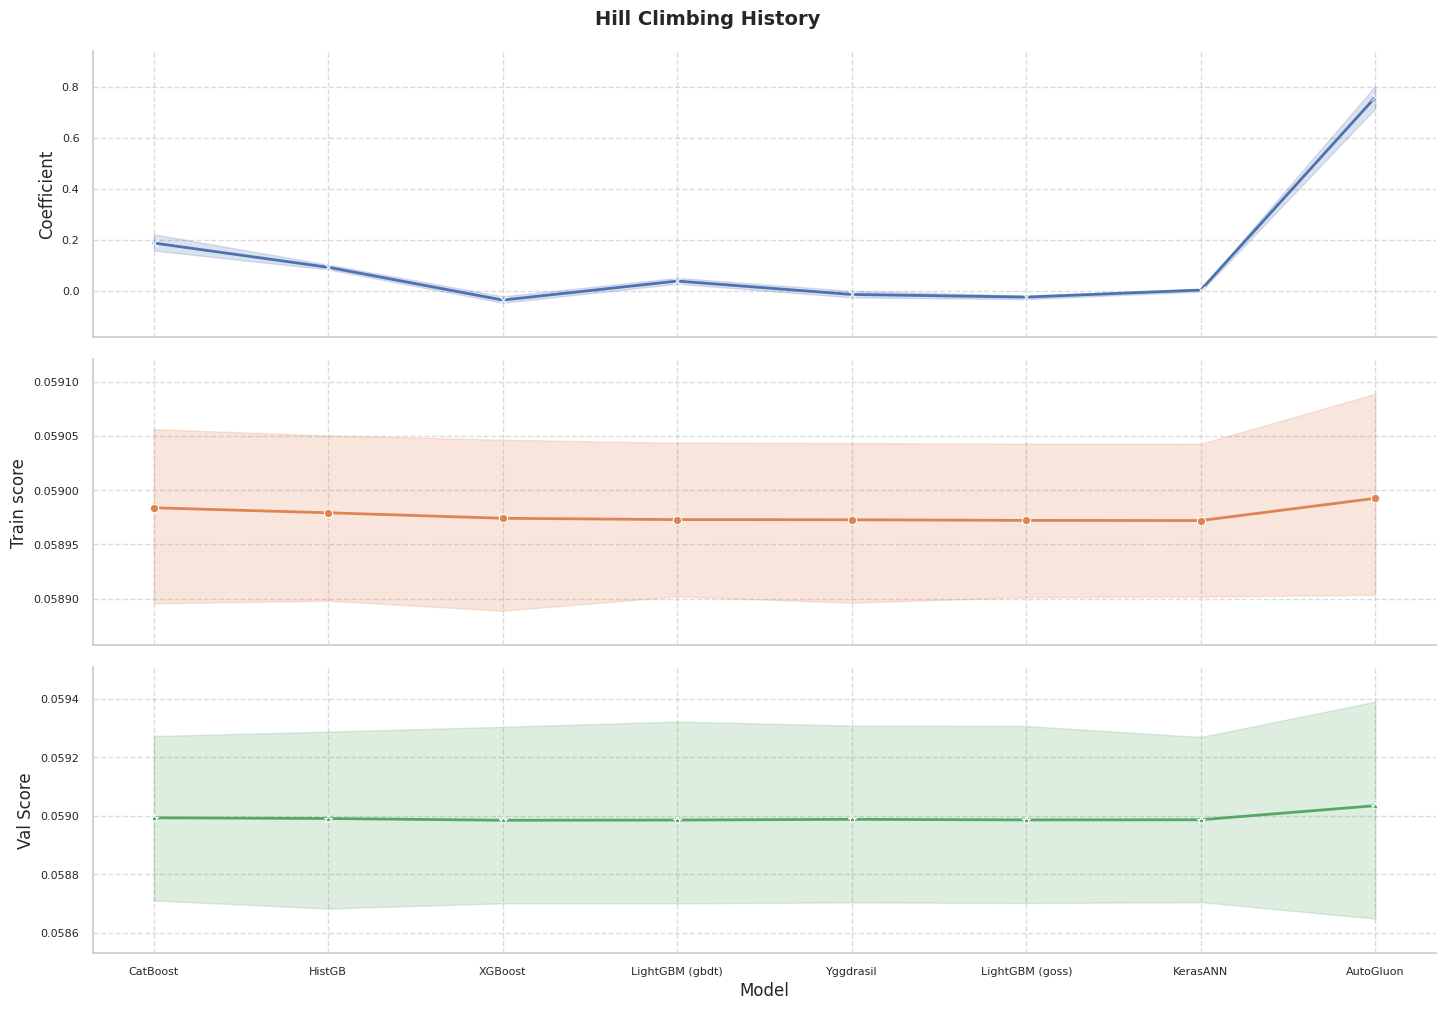

In [11]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context("notebook", font_scale=1.2)

def add_annotations(ax, x, y):
    for xi, yi in zip(x, y):
        ax.annotate(
            f'{yi:.6f}', (xi, yi),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            va='bottom',
            fontsize=8
        )

history = climber_cv.history

palette = sns.color_palette("deep")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

sns.lineplot(x=history.model[1:], y=history.coef[1:], color=palette[0], marker='x', ax=ax1, linewidth=2)
ax1.set_ylabel('Coefficient', fontsize=12)
ax1.spines[['top', 'right']].set_visible(False)

sns.lineplot(x=history.model[1:], y=history.train_score[1:], color=palette[1], marker='o', ax=ax2, linewidth=2)
ax2.set_ylabel('Train score', fontsize=12)
ax2.spines[['top', 'right']].set_visible(False)

sns.lineplot(x=history.model[1:], y=history.val_score[1:], color=palette[2], marker='*', ax=ax3, linewidth=2)
ax3.set_ylabel('Val Score', fontsize=12)
ax3.set_xlabel('Model', fontsize=12)
ax3.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
fig.suptitle('Hill Climbing History', y=1.02, fontsize=14, fontweight='bold')

for ax in [ax1, ax2, ax3]:
    ax.tick_params(labelsize=8)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - (ymax-ymin)*0.1, ymax + (ymax-ymin)*0.1)

plt.show()

In [12]:
scores["Hill Climbing CV"] = climber_cv.fold_scores

sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = np.expm1(climber_cv.predict(test_preds))
sub.to_csv(f"sub_hill-climbing-cv_{climber.best_score:.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.200072
1,750001,107.732672
2,750002,87.205539
3,750003,125.758622
4,750004,75.973985


# Final scores

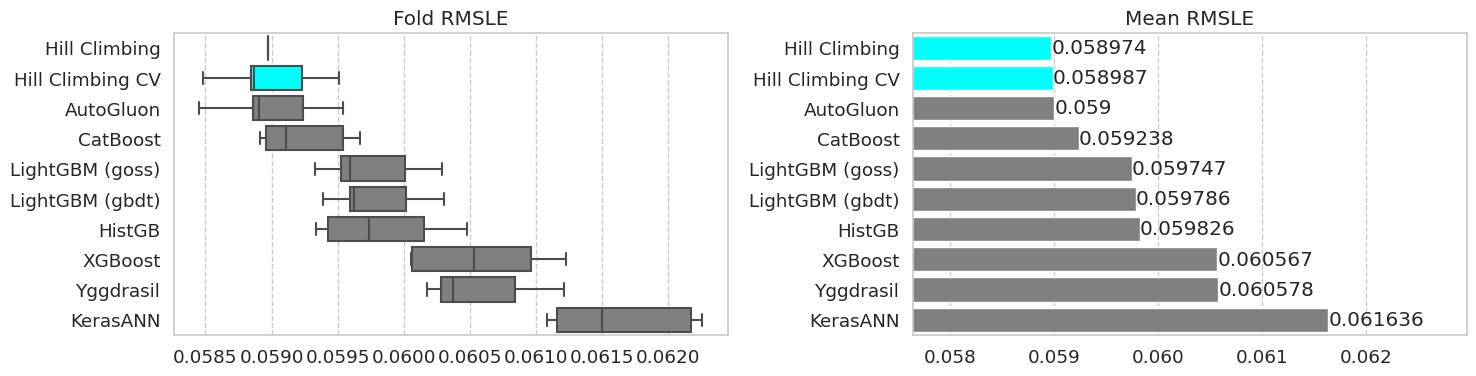

In [13]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold RMSLE")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean RMSLE")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "hill" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()